In [76]:
import os
import random

import numpy as np
from PIL import Image, ImageEnhance

from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras import Model # type: ignore
from tensorflow.keras.layers import Flatten, Dropout, Dense # type: ignore
from tensorflow.keras import Input # type: ignore
from tensorflow.keras.preprocessing.image import load_img, img_to_array # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.applications import VGG16 # type: ignore

from sklearn.utils import shuffle

In [50]:
# Directories
train = r"E:\Projects\CancerDetection\data\Training"
test = r"E:\Projects\CancerDetection\data\Testing"

In [36]:
# Load and Shuffle Data
def load_data(data_dir):
    data = [] 
    labels = []
    for label in os.listdir(data_dir):
        for img in os.listdir(os.path.join(data_dir, label)):
            img_path = os.path.join(data_dir, label, img)
            data.append(img_path)
            labels.append(label)
    return shuffle(data, labels)

data, labels = load_data(train)

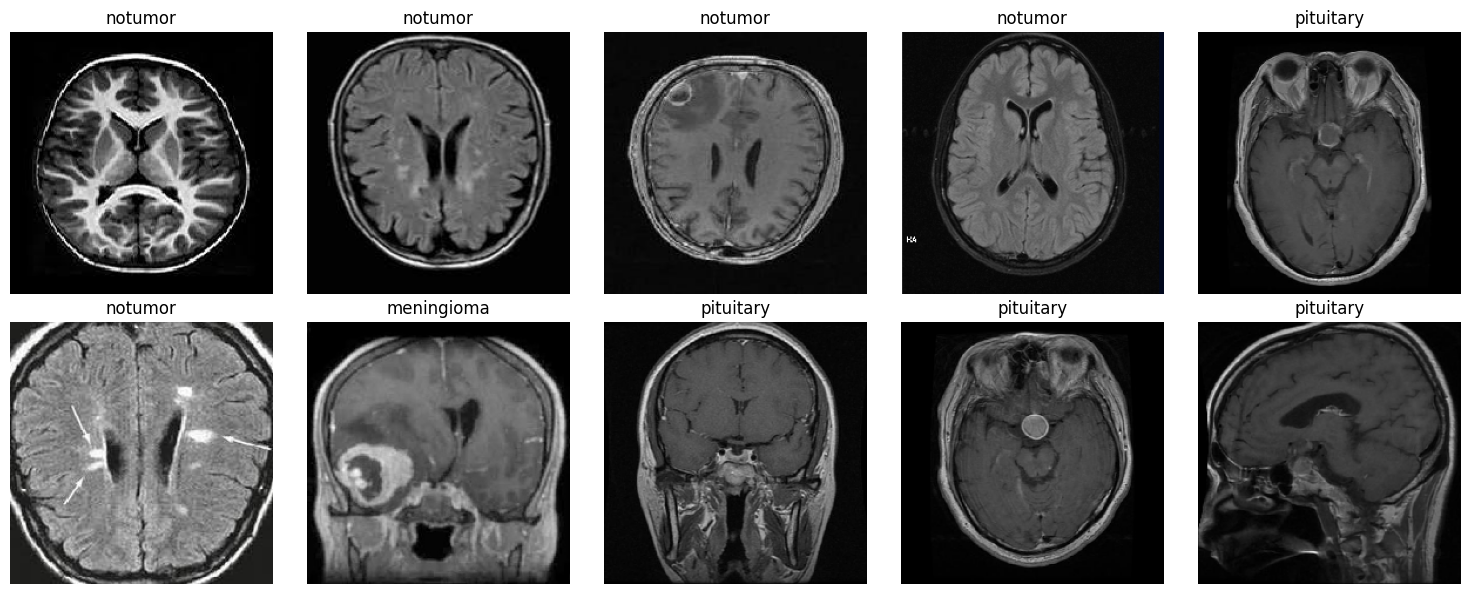

In [37]:
# data
import matplotlib.pyplot as plt

random.seed(42)

rand_indices = random.sample(range(len(data)), 10)

fig, ax = plt.subplots(2, 5, figsize=(15, 6))
ax = ax.flatten()
for i, idx in enumerate(rand_indices):
    img = load_img(data[idx], target_size=(224, 224))
    ax[i].imshow(img)
    ax[i].set_title(labels[idx])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [38]:
for i, idx in enumerate(rand_indices):
    print(i, idx)

0 5238
1 912
2 204
3 2253
4 2006
5 1828
6 1143
7 839
8 5543
9 4467


In [ ]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  
    image = np.array(image) / 255.0 
    return image
         
# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(128, 128))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels
def encode_label(labels):
    unique_labels = os.listdir(train)  # Unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths) 
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels) 
            yield batch_images, batch_labels  # Yield the batch"

In [40]:
ImageSize = 128

BASEMODEL = VGG16(
    include_top=False, 
    input_shape=(ImageSize, ImageSize, 3), 
    weights='imagenet'
)

# Freeze layers
for layer in BASEMODEL.layers:
    layer.trainable = False

BASEMODEL.layers[-2].trainable = True  
BASEMODEL.layers[-3].trainable = True
BASEMODEL.layers[-4].trainable = True


# model
model = Sequential()
model.add(Input(shape=(ImageSize, ImageSize, 3)))
model.add(BASEMODEL)
model.add(Flatten())
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(len(os.listdir(train)), activation='softmax'))

In [41]:
model.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss='sparse_categorical_crossentropy', 
    metrics=['sparse_categorical_accuracy'])

In [43]:
BatchSize = 32
STEPS = int(len(data) / BatchSize)
EPOCHS = 10

model.fit(
    datagen(data, labels, batch_size=BatchSize, epochs=EPOCHS), 
    steps_per_epoch=STEPS, 
    epochs=EPOCHS,
    verbose=1,
)

Epoch 1/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - loss: 0.6596 - sparse_categorical_accuracy: 0.7352
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - loss: 0.2608 - sparse_categorical_accuracy: 0.9024
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - loss: 0.1644 - sparse_categorical_accuracy: 0.9363
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - loss: 0.1279 - sparse_categorical_accuracy: 0.9518
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - loss: 0.1212 - sparse_categorical_accuracy: 0.9505
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - loss: 0.0647 - sparse_categorical_accuracy: 0.9766
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - loss: 0.0621 - sparse_categorical_accuracy: 0.9746
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - loss: 0.0437 - sparse_categorical_accuracy: 0.9851
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - loss: 0.0469 - sparse_categorical_accuracy: 0.9838
Epoch 10/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 207s 

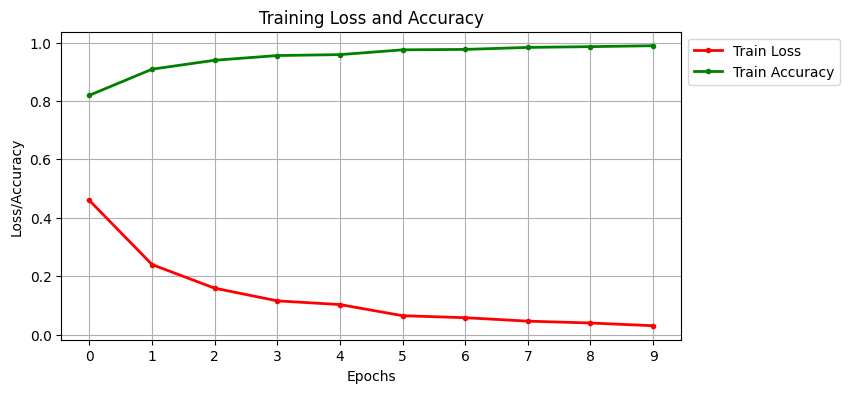

In [48]:
plt.figure(figsize=(8, 4))
plt.grid(True)
plt.plot(model.history.history['loss'], '.r-', linewidth=2, label='Train Loss')
plt.plot(model.history.history['sparse_categorical_accuracy'], '.g-', linewidth=2, label='Train Accuracy')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.xticks([x for x in range(0, EPOCHS)])
plt.legend(['Train Loss', 'Train Accuracy'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

test_data, test_labels = load_data(test)

test_images = open_images(test_data)

test_labels_encoded = encode_label(test_labels)

test_predictions = model.predict(test_images)

print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 823ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       300
           1       0.96      0.90      0.93       306
           2       0.98      1.00      0.99       405
           3       0.96      1.00      0.98       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



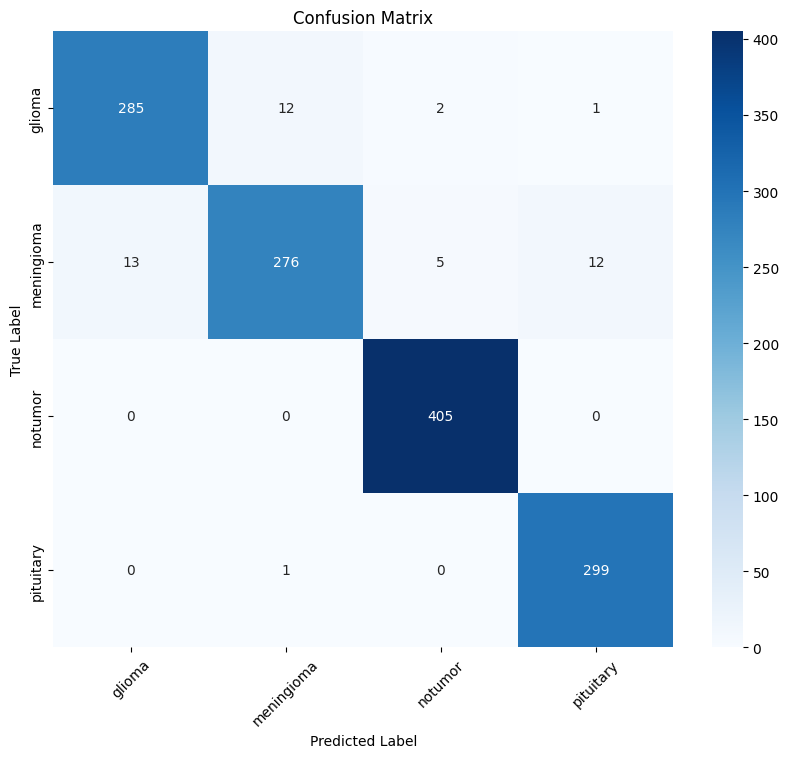

In [65]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=os.listdir(train), yticklabels=os.listdir(train))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.ylabel('True Label')
plt.show()

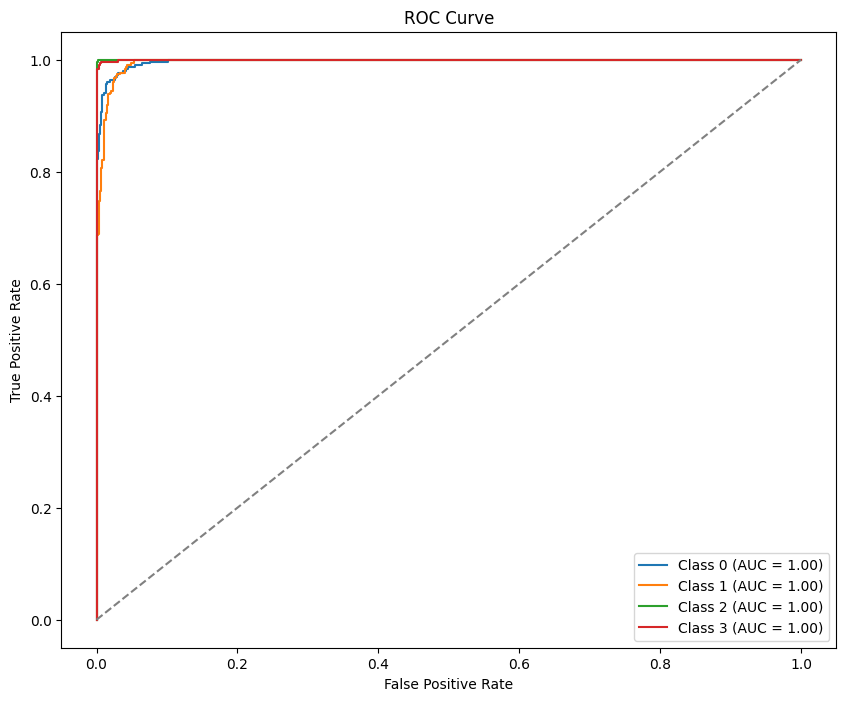

In [67]:
from sklearn.metrics import roc_curve, auc

test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train))))
test_predictions_bin = test_predictions  


fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line\n",
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [68]:
# Save the model
model.save("model.h5")

## Prediction System

In [101]:
class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(image_path, model):
    try:
        image = load_img(image_path, target_size=(128, 128))
        image = img_to_array(image) / 255.0
        image = np.expand_dims(image, axis=0)

        prediction = model.predict(image)
        predicted_class_index = np.argmax(prediction)
        confidence_score = np.max(prediction, axis=1)[0]

        if class_labels[predicted_class_index] == 'notumor':
            result = f"Image: {image_path} \n No Tumor Detected"
        else:
            result = f"Image: {image_path} \n Tumor detected: {(class_labels[predicted_class_index]).capitalize()} \n With confidence: {confidence_score*100:.2f}%"
        
        # display
        plt.figure(figsize=(6, 6))
        plt.imshow(load_img(image_path))
        plt.axis('off')
        plt.title(f"result: \n {result}")
        plt.show()
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


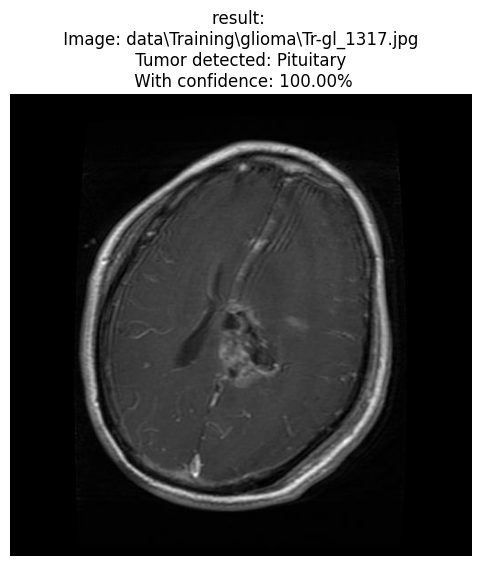

In [103]:
image_path = r"data\Training\glioma\Tr-gl_1317.jpg"
detect_and_display(image_path, model)